- Feature Engineering extra method: +0.5 points for using additional transformer embedding, besides the mandatory one.
- Classification Models extra method (encoder): +1 point for using another transformer encoder model (RoBERTa), besides the mandatory one.

In [37]:
!pip install python-dotenv
!pip install langchain-openai
# !pip install langchain-community
# !pip install -U langchain-huggingface

In [38]:
from utils import *
import pickle
import os
from dotenv import load_dotenv
from openai import AzureOpenAI
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [39]:
# Load the train/val split from the pickle file
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert DataFrames to list
train_texts = data['x_train']['text'].tolist()
val_texts = data['x_val']['text'].tolist()

# Convert Series to list
train_labels = data['y_train'].tolist()
val_labels = data['y_val'].tolist()

# Check
print("Train samples:", len(train_texts), len(train_labels))
print("Validation samples:", len(val_texts), len(val_labels))

Train samples: 7634 7634
Validation samples: 1909 1909


In [40]:
# # Set Azure OpenAI environment variables
# os.environ["AZURE_OPENAI_KEY"] = "b6b4fa7db9864e2f87f13334d7676f42"
# os.environ["AZURE_OPENAI_ENDPOINT"] = "https://novaimsplayground.openai.azure.com/"

# # Initialize Azure OpenAI client
# client = AzureOpenAI(
#     api_key=os.getenv("AZURE_OPENAI_KEY"),
#     api_version="2024-02-01",
#     azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
# )

In [41]:
# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


In [42]:
# Define deployment name
embedding_model_deployment = "text-embedding-3-small"

# Define function to get embeddings
def get_embeddings(texts, cache_file, delay=1.0, batch_size=32, force_reload=False):
    import math
    
    # Check if the cache file exists and if we should force reload
    if not force_reload and os.path.exists(cache_file):
        print(f"Loading embeddings from {cache_file}...")
        with open(cache_file, "rb") as f:
            return pickle.load(f)
    
    # If not, generate embeddings
    print(f"Generating embeddings in batches and saving to {cache_file}...")
    embeddings = []
    num_batches = math.ceil(len(texts) / batch_size)
    
    for i in tqdm(range(num_batches)):
        # Get the current batch of texts
        batch_texts = texts[i*batch_size : (i+1)*batch_size]
        try:
            response = client.embeddings.create(
                input=batch_texts,
                model=embedding_model_deployment
            )
            batch_embeddings = [item.embedding for item in response.data]
            embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error on batch {i}: {e}")
            # Append zero vectors for this batch
            embeddings.extend([[0.0]*1536]*len(batch_texts))
        
        # Respect the rate limit
        time.sleep(delay)
    
    # Save the embeddings to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(embeddings, f)
    
    return embeddings

In [43]:
# Get embeddings for train and validation sets
X_train = np.array(get_embeddings(train_texts, "X_train_te3s_embeddings.pkl", batch_size=32, force_reload=False))
X_val = np.array(get_embeddings(val_texts, "X_val_te3s_embeddings.pkl", batch_size=32, force_reload=False))

# Labels
y_train = np.array(train_labels)
y_val = np.array(val_labels)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [44]:
def inspect_texts(texts, name=""):
    non_strings = [i for i, t in enumerate(texts) if not isinstance(t, str)]
    empty_strings = [i for i, t in enumerate(texts) if isinstance(t, str) and t.strip() == ""]
    long_texts = [i for i, t in enumerate(texts) if isinstance(t, str) and len(t) > 16000]  # ~4 chars/token

    print(f"\n{name} Check:")
    print(f"  Non-string entries: {len(non_strings)} → {non_strings[:5]}")
    print(f"  Empty strings: {len(empty_strings)} → {empty_strings[:5]}")
    print(f"  Very long texts (>16k chars): {len(long_texts)} → {long_texts[:5]}")

    return {
        "non_strings": non_strings,
        "empty_strings": empty_strings,
        "long_texts": long_texts
    }

# Run checks
train_issues = inspect_texts(train_texts, "Train")
val_issues = inspect_texts(val_texts, "Validation")


Train Check:
  Non-string entries: 0 → []
  Empty strings: 4 → [1325, 3361, 3380, 7547]
  Very long texts (>16k chars): 0 → []

Validation Check:
  Non-string entries: 0 → []
  Empty strings: 0 → []
  Very long texts (>16k chars): 0 → []


In [ ]:
# Train and predict
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

In [46]:
# Display metrics
metrics_df = get_metrics_df(
    "LR with text-embedding-3-small",
    y_train, y_train_pred, y_val, y_val_pred
)
metrics_df

,Model,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,LR with text-embedding-3-small,0.7695,0.7397,0.8181,0.7965,0.7365,0.705,0.8352,0.8167


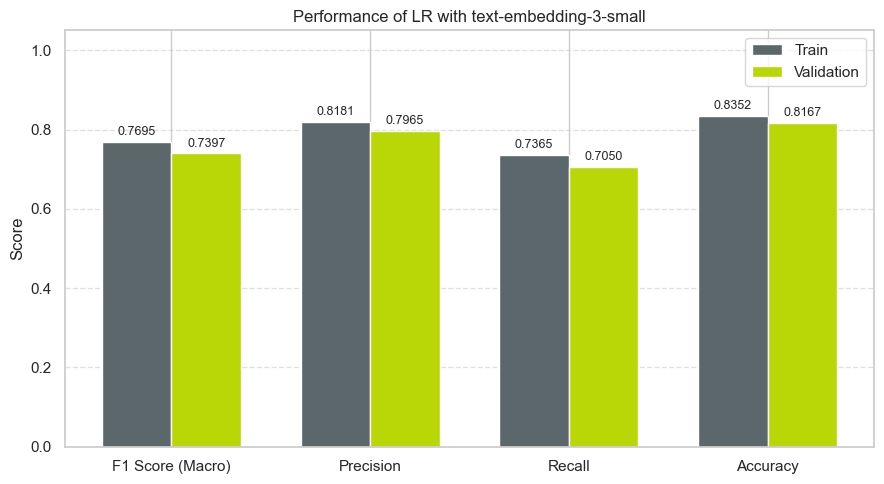

In [47]:
# Plot metrics
plot_metrics(y_train, y_train_pred, y_val, y_val_pred, title="Performance of LR with text-embedding-3-small")

In [52]:
# Load the test dataset
test_data = pd.read_csv("../data/test.csv")
test_texts = test_data["text"].tolist()

# Get embeddings for train and validation sets
X_test = np.array(get_embeddings(train_texts, "X_test_te3s_embeddings.pkl", batch_size=32, force_reload=False))

Generating embeddings in batches and saving to X_test_te3s_embeddings.pkl...


  9%|▉         | 21/239 [02:35<26:52,  7.40s/it]  


KeyboardInterrupt: 

In [ ]:
# Predict labels with the trained classifier
pred_labels = clf.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    "id": test_data["id"],
    "label": pred_labels
})

# Save submission to CSV
submission.to_csv("pred_25.csv", index=False)
print("Submission file saved as pred_25.csv")

In [ ]:
# Load the predictions from the saved CSV file
pred_25 = pd.read_csv("pred_25.csv")
pred_25.head()